In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset, SubsetRandomSampler
import torchvision
from torchvision import transforms
from torch import nn
from torch import functional as F

from sklearn.model_selection import StratifiedKFold
from torchmetrics import AUROC

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Dataset init

In [ ]:
# Dataset creation
class MyDataset(Dataset):
    def __init__(self, file_name, transform=None):
        df = pd.read_csv(file_name)
        
        #self.X = df.drop(['ID_code', 'target'], axis=1).values
        self.X = df.drop(['ID_code', 'target'], axis=1)

        #FE##
        features = self.X.columns
        self.X['sum'] = self.X[features].sum(axis=1)  
        self.X['min'] = self.X[features].min(axis=1)
        self.X['max'] = self.X[features].max(axis=1)
        self.X['mean'] = self.X[features].mean(axis=1)
        self.X['std'] = self.X[features].std(axis=1)
        self.X['skew'] = self.X[features].skew(axis=1)
        self.X['kurt'] = self.X[features].kurtosis(axis=1)
        self.X['med'] = self.X[features].median(axis=1)
        ###
        
        self.X = self.X.values
        self.y = df['target'].values
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        idx = index.tolist()
        
        x_batch = self.X[index]
        y_batch = self.y[index]
            
        if self.transform is not None:
            x_batch = self.transform(x_batch)
            y_batch = self.transform(y_batch)

        return x_batch, y_batch, idx

In [ ]:
# Custom transformation
class to_tens():
    def __call__(self, data):
        return torch.tensor(data, dtype=torch.float32)
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
path = 'drive/MyDrive/sasha_babuin/data_santander/data/train.csv'

In [ ]:
dataset = MyDataset(
    path,
    transform=to_tens()
)

In [ ]:
dataset.X.shape

(200000, 208)

Model init

In [ ]:
class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()
        self.dropout = nn.Dropout(0.5)
        
        self.bn0 = nn.BatchNorm1d(208)
        self.l1 = nn.Linear(208, 128)
        self.act1  = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(128)

        self.l4 = nn.Linear(128, 64)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(64)


        self.l2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(32)

        self.flat = nn.Flatten()
        
        self.l3 = nn.Linear(32, 1)
        #self.act3 = nn.Sigmoid()
        
    
    def forward(self, x):
        #print(x.shape)
        x = self.bn0(x)
        x = self.dropout(x)

        x = self.l1(x)
        x = self.act1(x)
        x = self.bn1(x)
        #x = self.dropout(x)
        
        x = self.l4(x)
        x = self.act4(x)
        x = self.bn4(x)
        #x = self.dropout(x)

        x = self.l2(x)
        x = self.act2(x)
        x = self.bn2(x)

        x = self.flat(x)

        x = self.dropout(x)
        x = self.l3(x)
        #x = self.act3(x)
        
        return x

Auxiliary functions

In [ ]:
def augment_counts(x, y, t_pos, t_neg):
        xs,xn = [],[]
        for i in range(t_pos):
            mask = y>0
            x1 = x[mask].copy()
            ids = np.arange(x1.shape[0])
            for c in range(208):
                np.random.shuffle(ids)
                x1[:,c] = x1[ids][:,c]
              
            xs.append(x1)

        for i in range(t_neg):
            mask = y==0
            x1 = x[mask].copy()
            ids = np.arange(x1.shape[0])
            for c in range(208):
                np.random.shuffle(ids)
                x1[:,c] = x1[ids][:,c]
                
            xn.append(x1)

        xs = np.vstack(xs)
        xn = np.vstack(xn)
        ys = np.ones(xs.shape[0])
        yn = np.zeros(xn.shape[0])
        x = np.vstack([x,xs,xn])
        #x = np.vstack([x,xs])
        y = np.concatenate([y,ys, yn])
        
        return x,y

In [ ]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
def get_accuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.size(0)

In [ ]:
def train_model(model, fold, train_loader, device, loss_fn, opt, n_epochs: int):
    train_loss = []
    train_acc = []
    auroc = AUROC(num_classes=2)
    
    model.train(True) # enable dropout / batch_norm training behavior
    global ys
    for idx_batch, (X_batch, y_batch, _) in enumerate(train_loader):

        X_batch, y_batch = augment_counts(X_batch.numpy(), y_batch.numpy(), 2, 1)
        X_batch = torch.tensor(X_batch, dtype = torch.float32)
        y_batch = torch.tensor(y_batch, dtype = torch.float32)

        opt.zero_grad()
        
        # move data to target device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
    
        # make f/w and b/w pass
        predictions = model(X_batch).view(-1)
        loss = loss_fn(predictions, y_batch)
        loss.backward()
        opt.step()
        # step for lr
        #my_lr_scheduler.step()
        
        train_loss.append(loss.item())
        #accuracy = get_accuracy(y_batch, predictions)
        accuracy = auroc(predictions, torch.tensor(y_batch, dtype=torch.int32).to(device))
        train_acc.append(accuracy)
    
    return train_loss, train_acc

In [ ]:
def test_model(model, fold, test_loader, device, loss_fn, test = False):
    model.eval() # disable dropout / use averages for batch_norm
    pred_idx = []
    predictions_list = []
    test_loss = []
    test_acc = []
    auroc = AUROC(num_classes=2)
    
    with torch.no_grad():
        for X_batch, y_batch, idx in test_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # compute predictions
            predictions = model(X_batch).view(-1)
            
            loss = loss_fn(predictions, y_batch)
            test_loss.append(loss.item())
                
            #accuracy = get_accuracy(y_batch, predictions)
            accuracy = auroc(predictions, torch.tensor(y_batch, dtype=torch.int32).to(device))
            test_acc.append(accuracy)

            pred_idx.append(idx)
            predictions_list.append(predictions)

    if test:
        return test_loss, test_acc, pred_idx, predictions_list 
    else:
        return test_loss, test_acc, pred_idx

In [ ]:
def make_test_prediction(X, batch_size, model):
  df_predictions = {'prediction': []}
  for i in range(0, X.shape[0], batch_size):
    X_batch = X[i:i + batch_size]

    test_preds = model(X_batch).view(-1)
    
    df_predictions['prediction'].extend(test_preds.detach().numpy())
  return pd.DataFrame(df_predictions)

Train loop

In [ ]:
model = Simple_NN().to(device)
model.apply(reset_weights)

Simple_NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (bn0): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=208, out_features=128, bias=True)
  (act1): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=128, out_features=64, bias=True)
  (act4): ReLU()
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=64, out_features=32, bias=True)
  (act2): ReLU()
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (l3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
sum(dataset.y == 0) / sum(dataset.y == 1)

8.951238929246692

In [ ]:
# training parameters
n_splits = 5 # Number of K-fold Splits
batch_size = 264 # Num of batches for model training
num_epochs = 40

sk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=4590)

#loss_func = nn.BCELoss()
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(8.951238929246692).to(device))
#optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
#optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)
my_lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=0.001, max_lr=0.005, step_size_up=2000, mode='triangular', scale_mode='exp_range', gamma=0.99994, cycle_momentum=False)

#my_lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=1e-3, max_lr=1e-2, step_size_up=150, mode='triangular', scale_mode='cycle')
#my_lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=6e-3, total_steps=num_epochs*batch_size)

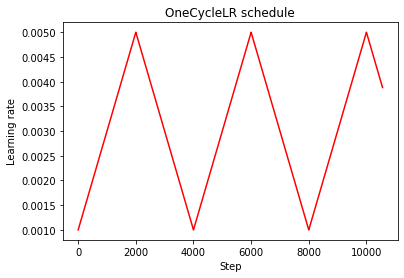

In [ ]:
ys = []
for _ in range(num_epochs):
    for _ in range(batch_size):
        ys.append(optimizer.param_groups[0]['lr'])
        my_lr_scheduler.step()
plt.title('OneCycleLR schedule')
plt.ylabel('Learning rate')
plt.xlabel('Step')
plt.plot(ys, c='red')
plt.show()

In [ ]:
dataset.X.shape[0]

200000

In [ ]:
predictions_train = np.zeros(dataset.X.shape[0])
for fold, (train_idx,test_idx) in enumerate(sk.split(dataset.X, dataset.y)):
    train_loss_fold = []
    test_loss_fold = []
    
    train_acc_fold = []
    test_acc_fold = []
    
    print('----------------------Fold № {}----------------------'.format(fold))
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    model.apply(reset_weights) # each cross-validation fold starts from some random initial state

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_acc = train_model(model, fold, train_loader, device, loss_func, optimizer, num_epochs)
        test_loss, test_acc, _ = test_model(model, fold, test_loader, device, loss_func, test = False)

        # print the results for this epoch:
        print(f'Epoch {epoch} of {num_epochs} took {time.time() - start_time:.3f}s')
        
        # loss
        train_loss_fold.append(np.mean(train_loss))
        test_loss_fold.append(np.mean(test_loss))
        # accuracy
        train_acc_fold.append(np.mean(train_acc))
        test_acc_fold.append(np.mean(test_acc))
        
        print(f"\tTraining loss: {train_loss_fold[-1]:.6f}")
        print(f"\tTraining accuracy: {train_acc_fold[-1]:.6f}")
        print(' ')
        print(f"\tTesting loss: {test_loss_fold[-1]:.3f}")
        print(f"\tTesting accuracy: {test_acc_fold[-1]:.3f}")
        
    __, _, pred_idx, prediction = test_model(model, fold, test_loader, device, loss_func, test = True)
    
    pred_lst = list(batch.cpu().data.numpy() for batch in prediction)
    pred_ar = np.array(pred_lst).reshape(-1)

    idx_lst = list(batch.cpu().data.numpy() for batch in pred_idx)
    idx_ar = np.array(idx_lst).reshape(-1)
    
    predictions_train[idx_ar] = pred_ar
    break

----------------------Fold № 0----------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 of 40 took 15.127s
	Training loss: 1.216886
	Training accuracy: 0.759867
 
	Testing loss: 0.917
	Testing accuracy: 0.862
Epoch 1 of 40 took 15.341s
	Training loss: 1.188476
	Training accuracy: 0.775481
 
	Testing loss: 0.885
	Testing accuracy: 0.866
Epoch 2 of 40 took 17.287s
	Training loss: 1.180207
	Training accuracy: 0.781179
 
	Testing loss: 0.891
	Testing accuracy: 0.869


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 3 of 40 took 14.266s
	Training loss: 1.177067
	Training accuracy: 0.780015
 
	Testing loss: 0.929
	Testing accuracy: 0.867
Epoch 4 of 40 took 16.990s
	Training loss: 1.171583
	Training accuracy: 0.783552
 
	Testing loss: 0.929
	Testing accuracy: 0.871
Epoch 5 of 40 took 14.024s
	Training loss: 1.169399
	Training accuracy: 0.785145
 
	Testing loss: 0.927
	Testing accuracy: 0.870
Epoch 6 of 40 took 14.095s
	Training loss: 1.168081
	Training accuracy: 0.786337
 
	Testing loss: 0.925
	Testing accuracy: 0.873
Epoch 7 of 40 took 15.607s
	Training loss: 1.168477
	Training accuracy: 0.786211
 
	Testing loss: 0.915
	Testing accuracy: 0.873
Epoch 8 of 40 took 14.278s
	Training loss: 1.164236
	Training accuracy: 0.787965
 
	Testing loss: 0.957
	Testing accuracy: 0.873
Epoch 9 of 40 took 14.898s
	Training loss: 1.160157
	Training accuracy: 0.789765
 
	Testing loss: 0.943
	Testing accuracy: 0.873
Epoch 10 of 40 took 16.219s
	Training loss: 1.162494
	Training accuracy: 0.786773
 
	Testing loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


IndexError: ignored

In [ ]:
idx_ar

array([ 42682, 195133, 190508, ..., 142213, 181807, 195063])

In [ ]:
roc_auc_score(dataset.y, predictions_train)

0.8634396568486328

Submission

In [ ]:
# make predictions on a test csv
path = 'drive/MyDrive/sasha_babuin/data_santander/data/test.csv'
df = pd.read_csv(path)
X = df.drop(['ID_code'], axis=1).values
X = torch.tensor(X, dtype=torch.float32)

In [ ]:
# make predictions on a test csv
path = 'drive/MyDrive/sasha_babuin/data_santander/data/test.csv'
df = pd.read_csv(path)
X = df.drop(['ID_code'], axis=1)
features = X.columns
X['sum'] = X[features].sum(axis=1)  
X['min'] = X[features].min(axis=1)
X['max'] = X[features].max(axis=1)
X['mean'] = X[features].mean(axis=1)
X['std'] = X[features].std(axis=1)
X['skew'] = X[features].skew(axis=1)
X['kurt'] = X[features].kurtosis(axis=1)
X['med'] = X[features].median(axis=1)
X = X.values
X = torch.tensor(X, dtype=torch.float32)

In [ ]:
model.eval().to('cpu')
df_predictions = make_test_prediction(X, 10000, model)

In [ ]:
df_predictions = df_predictions.rename(columns={'prediction': 'target'}, index=lambda s: 'test_' + str(s))
df_predictions.index.name = 'ID_code'
path = 'drive/MyDrive/sasha_babuin/data_santander/CV_torch_test.csv'
df_predictions.to_csv(path)

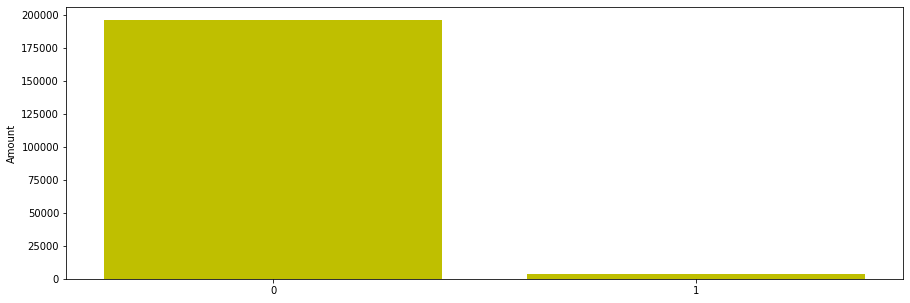

In [ ]:
# for binary
x = ['0', '1']
predictions = np.array(df_predictions)
y1 = [len(predictions[predictions < 0.5]), len(predictions[predictions > 0.5])]

plt.figure(figsize = (15,5))
plt.bar(x, y1, color='y')
plt.ylabel('Amount')

plt.show()

In [ ]:
print(predictions[predictions < 0.5].shape[0], predictions[predictions > 0.5].shape[0])

181064 18936


In [ ]:
print(predictions[predictions > 0.5].shape[0] / predictions[predictions < 0.5].shape[0])

0.018994049074753404
